In [1]:
import matplotlib.pyplot as plt

import glob, os, itertools
from pathlib import Path

from regions import PointSkyRegion, CircleSkyRegion

import numpy as np

import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time
from astropy.table import Table

from gammapy.data import DataStore, Observation, observatory_locations, EventList
from gammapy.datasets import (
    MapDataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import ASmoothMapEstimator, TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators.utils import resample_energy_edges, find_peaks, find_peaks_in_flux_map
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import (
    MapDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, RegionGeom, RegionNDMap, WcsGeom, Map, TimeMapAxis
from gammapy.modeling.models import (
    PowerLawNormSpectralModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel
)

import warnings

In [2]:
input_filenames = []
input_filenames.append(glob.glob(os.path.join("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Fermi/Experiment/", '*.fits')))
input_filenames = tuple(itertools.chain.from_iterable(input_filenames))

datastore = DataStore.from_events_files(np.sort(input_filenames), 
                                        irfs_paths="/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits")
datastore.hdu_table.write("hdu-index.fits.gz", overwrite=True)
datastore.obs_table.write("obs-index.fits.gz", overwrite=True)

In [3]:
print(f"The mean exposure of the runs is {np.mean(datastore.obs_table['LIVETIME']) * u.s}\n")
print(f"The total exposure time is {(np.sum(datastore.obs_table['LIVETIME']) * u.s).to('hr')}\n")
print(f"These are the selected runs: \n {datastore.obs_table['OBS_ID']}")

The mean exposure of the runs is 7200.0 s

The total exposure time is 50.0 h

These are the selected runs: 
 OBS_ID
------
     0
     1
    10
    11
    12
    13
    14
    15
    16
    17
   ...
    22
    23
    24
     3
     4
     5
     6
     7
     8
     9
Length = 25 rows


In [4]:
observations = datastore.get_observations(obs_id=list(datastore.obs_table['OBS_ID']))

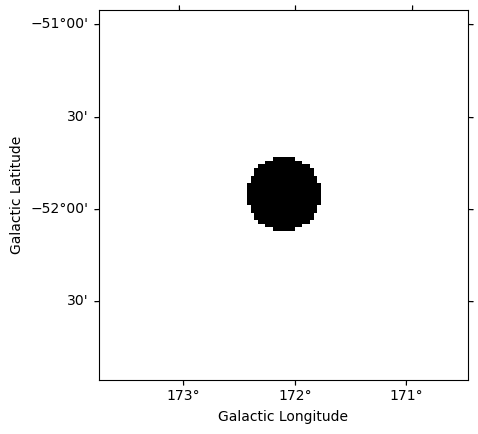

In [5]:
bkg = "FoV"

# we consider a square map of size 2.0 deg, spatially binned with bins of 0.02 deg:
# we define the ON region, assuming a circle of 0.3 deg of radius, for the source:
width = 2    #deg
binsz = 0.02 #deg 
radius= 0.2  #deg

target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")
on_region_radius = Angle(radius * u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

npix = int(width/binsz)

# let's define an exclusion region, in order to better estimate the bkg:
exclusion_region = CircleSkyRegion(
    center=target_position,
    radius=radius * u.deg,
)

geom_excl = WcsGeom.create(
    npix=(npix, npix), binsz=binsz, skydir=target_position.galactic, proj="TAN", frame="galactic"
    #npix=(npix, npix), binsz=binsz, skydir=w1.galactic, proj="TAN", frame="galactic"
)

exclusion_mask = ~geom_excl.region_mask([exclusion_region])
exclusion_mask.plot()
plt.show()

In [6]:
# Create the reconstruced energy range:
e_min, e_max = 0.1 * u.TeV, 100 * u.TeV
energy_axis = MapAxis.from_energy_bounds(
    e_min, e_max, nbin=10, per_decade=True, unit="TeV", name="energy"
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.01, 300, nbin=10, per_decade=True, unit="TeV", name="energy_true"
)

# if bkg == "FoV":
#     geom = WcsGeom.create(
#         skydir=(target_position.galactic.l.deg , target_position.galactic.b.deg),
#         binsz=binsz,
#         width=(width, width),
#         frame="galactic",
#         proj="CAR",
#         axes=[energy_axis],
#     )

#     stacked = MapDataset.create(
#         geom=geom, energy_axis_true=energy_axis_true, name="my-dataset"
#     )

#     dataset_maker = MapDatasetMaker()
    
#     maker_fov = FoVBackgroundMaker(method="scale", 
#                                    exclusion_mask=exclusion_mask,
#                                    )
    
# # let's impone a safe range for the analysis: we consider only events at a distance from the pointing direction < 3 deg.
# offset_max = 3 * u.deg
# safe_mask_masker = SafeMaskMaker(
#     methods=["aeff-default"], offset_max=offset_max
# #    methods=["offset-max", "aeff-default"], offset_max=offset_max
# #    methods=["offset-max", "aeff-max"], offset_max=offset_max, aeff_percent=10
# )

# # let's create the dataset for each observation and stack them all:
# for i, observation in enumerate(observations):
#     if bkg == "FoV":
#         dataset = dataset_maker.run(stacked.copy(name=str(observation.obs_id)), observation)
        
#         # A MapDataset is filled in this cutout geometry
#         dataset = safe_mask_masker.run(dataset, observation)
#         dataset = maker_fov.run(dataset)
        
#         # The data quality cut is applied
#         stacked.stack(dataset)
        
#         print(f"{i+1} of {len(observations)}, Background norm obs {observation.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}")

In [7]:
if bkg == "FoV":
    geom = WcsGeom.create(
        skydir=(target_position.galactic.l.deg , target_position.galactic.b.deg),
        binsz=binsz,
        width=(width, width),
        frame="galactic",
        proj="CAR",
        axes=[energy_axis],
    )

    template = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="my-dataset")

    stacked = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="my-dataset")

    dataset_maker = MapDatasetMaker()
    
    maker_fov = FoVBackgroundMaker(method="scale", 
                                   exclusion_mask=exclusion_mask,
                                   )
    
# let's impone a safe range for the analysis: we consider only events at a distance from the pointing direction < 3 deg.
offset_max = 3 * u.deg
safe_mask_masker = SafeMaskMaker(
    methods=["aeff-default"], offset_max=offset_max
#    methods=["offset-max", "aeff-default"], offset_max=offset_max
#    methods=["offset-max", "aeff-max"], offset_max=offset_max, aeff_percent=10
)

# let's create the dataset for each observation and stack them all:
for i, observation in enumerate(observations):
    if bkg == "FoV":
        dataset = dataset_maker.run(template.copy(name=str(observation.obs_id)), observation)
        
        # A MapDataset is filled in this cutout geometry
        dataset = safe_mask_masker.run(dataset, observation)
        dataset = maker_fov.run(dataset)
        
        # The data quality cut is applied
        stacked.stack(dataset)
        
        print(f"{i+1} of {len(observations)}, Background norm obs {observation.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}")

No default upper safe energy threshold defined for obs 0
No default lower safe energy threshold defined for obs 0


1 of 25, Background norm obs 0: 1.00


No default upper safe energy threshold defined for obs 1
No default lower safe energy threshold defined for obs 1


2 of 25, Background norm obs 1: 1.00


No default upper safe energy threshold defined for obs 10
No default lower safe energy threshold defined for obs 10


3 of 25, Background norm obs 10: 1.00


No default upper safe energy threshold defined for obs 11
No default lower safe energy threshold defined for obs 11


4 of 25, Background norm obs 11: 1.00


No default upper safe energy threshold defined for obs 12
No default lower safe energy threshold defined for obs 12


5 of 25, Background norm obs 12: 1.00


No default upper safe energy threshold defined for obs 13
No default lower safe energy threshold defined for obs 13


6 of 25, Background norm obs 13: 1.01


No default upper safe energy threshold defined for obs 14
No default lower safe energy threshold defined for obs 14


7 of 25, Background norm obs 14: 1.00


No default upper safe energy threshold defined for obs 15
No default lower safe energy threshold defined for obs 15


8 of 25, Background norm obs 15: 1.00


No default upper safe energy threshold defined for obs 16
No default lower safe energy threshold defined for obs 16


9 of 25, Background norm obs 16: 0.99


No default upper safe energy threshold defined for obs 17
No default lower safe energy threshold defined for obs 17


10 of 25, Background norm obs 17: 0.99


No default upper safe energy threshold defined for obs 18
No default lower safe energy threshold defined for obs 18


11 of 25, Background norm obs 18: 1.01


No default upper safe energy threshold defined for obs 19
No default lower safe energy threshold defined for obs 19


12 of 25, Background norm obs 19: 0.99


No default upper safe energy threshold defined for obs 2
No default lower safe energy threshold defined for obs 2


13 of 25, Background norm obs 2: 0.99


No default upper safe energy threshold defined for obs 20
No default lower safe energy threshold defined for obs 20


14 of 25, Background norm obs 20: 1.01


No default upper safe energy threshold defined for obs 21
No default lower safe energy threshold defined for obs 21


15 of 25, Background norm obs 21: 1.00


No default upper safe energy threshold defined for obs 22
No default lower safe energy threshold defined for obs 22


16 of 25, Background norm obs 22: 0.99


No default upper safe energy threshold defined for obs 23
No default lower safe energy threshold defined for obs 23


17 of 25, Background norm obs 23: 1.00


No default upper safe energy threshold defined for obs 24
No default lower safe energy threshold defined for obs 24


18 of 25, Background norm obs 24: 0.99


No default upper safe energy threshold defined for obs 3
No default lower safe energy threshold defined for obs 3


19 of 25, Background norm obs 3: 1.00


No default upper safe energy threshold defined for obs 4
No default lower safe energy threshold defined for obs 4


20 of 25, Background norm obs 4: 1.01


No default upper safe energy threshold defined for obs 5
No default lower safe energy threshold defined for obs 5


21 of 25, Background norm obs 5: 1.00


No default upper safe energy threshold defined for obs 6
No default lower safe energy threshold defined for obs 6


22 of 25, Background norm obs 6: 0.99


No default upper safe energy threshold defined for obs 7
No default lower safe energy threshold defined for obs 7


23 of 25, Background norm obs 7: 1.00


No default upper safe energy threshold defined for obs 8
No default lower safe energy threshold defined for obs 8


24 of 25, Background norm obs 8: 1.00


No default upper safe energy threshold defined for obs 9
No default lower safe energy threshold defined for obs 9


25 of 25, Background norm obs 9: 0.99


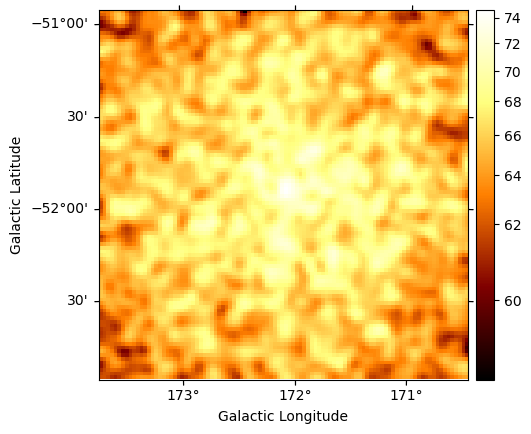

In [8]:
# plot the counts map
if bkg == "FoV":
    stacked.counts.sum_over_axes().smooth(0.03 * u.deg).plot(stretch="sqrt", add_cbar=True)
plt.show()

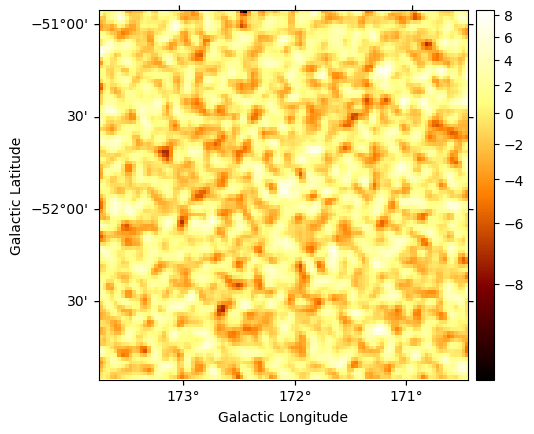

In [9]:
# plot the excess map
excess = stacked.excess.sum_over_axes()
excess.smooth("0.02 deg").plot(stretch="sqrt", add_cbar=True)
plt.show()

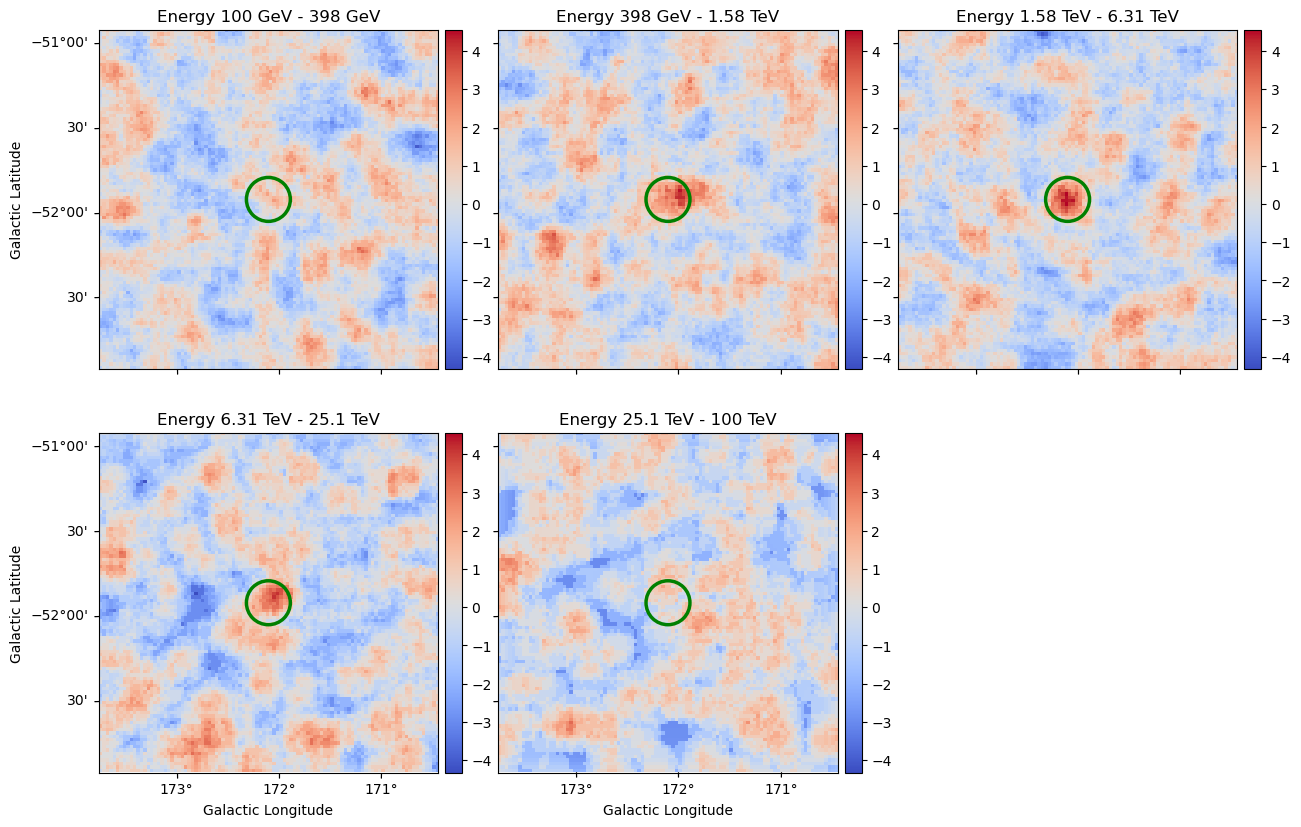

In [10]:
# let's consider more than one energy bin and a correlation radius of 0.1 deg
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional="all",
    #energy_edges=[0.5, 2, 5, 10, 30, 100] * u.TeV,
    energy_edges=energy_axis.downsample(6).edges,
)

result = estimator.run(stacked)
ax = result["sqrt_ts"].plot_grid(
    figsize=(15, 10), cmap="coolwarm", add_cbar=True, 
    vmin=np.min(result["sqrt_ts"].data[~np.isnan(result["sqrt_ts"].data)]), 
    vmax=np.max(result["sqrt_ts"].data[~np.isnan(result["sqrt_ts"].data)]), 
    ncols=3)

for p in ax.reshape(ax.size):
    p.scatter(
        target_position.galactic.l.deg, target_position.galactic.b.deg,
        transform=p.get_transform("galactic"),
        color="None", edgecolor="g", marker="o",
        s=1000, lw=2.5,
    )

plt.show()

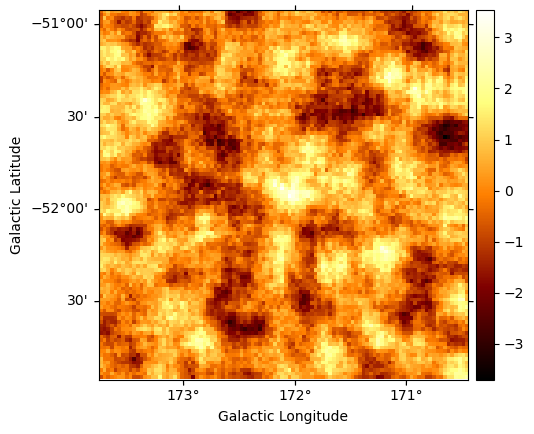

In [11]:
excess_estimator_integrated = ExcessMapEstimator(
    correlation_radius="0.1 deg", selection_optional="all", n_sigma=1,
    n_sigma_ul=3,
    energy_edges=[0.1, 100] * u.TeV,
    correlate_off=True
)
excess_integrated = excess_estimator_integrated.run(stacked)

excess_integrated["sqrt_ts"].plot(add_cbar=True)
plt.show()

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
3.5397,51,49,40.64009,-0.00019
3.1801,85,78,40.52799,0.88650
3.1094,76,35,40.08190,0.12952


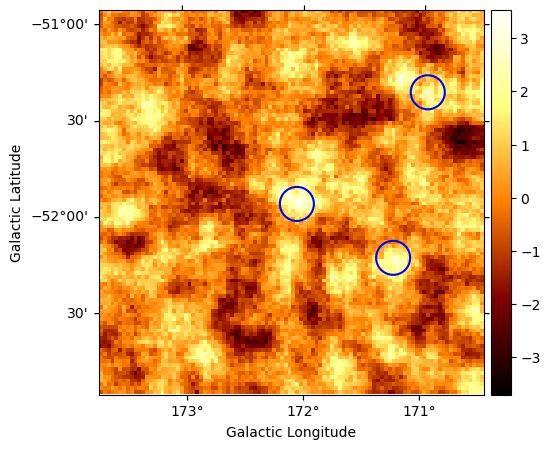

In [ ]:
# set a threshold of detection at 4 sigma and a minimum distance amongst detected source of 0.2 deg:
sources = find_peaks(excess_integrated["sqrt_ts"], threshold=5, min_distance="0.2 deg")
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = excess_integrated["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"], sources["dec"],
   transform=ax.get_transform("icrs"),
    color="None", edgecolor="b", marker="o",
    s=600, lw=1.5,
)
plt.show()